<a href="https://colab.research.google.com/github/davideandres95/ml_comm/blob/main/tut08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Tutorial 8: Mapper and PCA
December 16, 2021

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch            
from torch import nn, optim

In [ ]:
def one_hot(a, M):
    onehot = np.zeros(M)
    onehot[a] = 1
    return onehot

##### Problem 6.3 - SNR Constraint
In this problem, we consider an SNR constraint as introduced in Section 6.1.3. 
Specifically, we consider a complex signal, which we represent by a real signal where two successive real symbols are the inphase and quadrature components, respectively, of one complex symbol, i.e.,
$$x_{2i}x_{2i+1} \leftrightarrow  c_i = x_{2i} + j · x_{2i+1}$$

We normalize the average power of the signal, i.e., for a batch size of $n_\text{batch}$ complex
symbols, we impose
$$ \frac{1}{2n_\text{batch}} \sum_{i=0}^{n_\text{batch}-1} x_i ^2 = P .$$
After normalization, we add zero mean Gaussian noise.

The task is now to learn a 2D constellation with 16 complex symbols

* 1) Implement the normalization layer followed by AWGN as differentiable function in pytorch.

In [ ]:
def normalization(x, P):
    c = torch.mean(x**2)
    return torch.sqrt(P / c) * x

In [ ]:
def awgn(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return torch.add(x, noise_t)

* 2) For a one-hot representation of the message, implement a linear unit with M = 16 inputs and 2 outputs as a mapper at the transmitter, and a linear unit with 2 inputs and M = 16 outputs as demapper at the receiver

In [ ]:
class Mapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(16, 32)
        self.lin2 = nn.Linear(32, 32)
        self.lin3 = nn.Linear(32, 2)
        
    def forward(self, y):
        return self.lin3(self.lin2(self.lin1(y)))

In [ ]:
class Demapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(2, 32)
        self.lin2 = nn.Linear(32, 32)
        self.lin3 = nn.Linear(32, 16)
        
    def forward(self, y):
        return self.lin3(self.lin2(self.lin1(y)))

* 3) Jointly train mapper and demapper w.r.t. CE loss for SNR equal to $\{0, 2, \dots , 10\}$ dB and plot the learned constellations.

In [ ]:
# Generate data
M = 16
n = 10000
a = np.random.choice(range(M), size= n)
onehot = np.array([one_hot(a[i], M) for i in range(n)])
# convert array to tensors
onehot_t = torch.tensor(onehot).float()
a_t = torch.tensor(a)
a_t = a_t.type(torch.LongTensor)
# loss function
loss_fn = nn.CrossEntropyLoss()

---SNR = 0 dB---
epoch 0: Loss = 4.0615 dB
epoch 500: Loss = 2.9944 dB
epoch 1000: Loss = 3.0244 dB
epoch 1500: Loss = 3.0017 dB
epoch 2000: Loss = 2.9961 dB
epoch 2500: Loss = 3.0072 dB
epoch 3000: Loss = 2.9927 dB
epoch 3500: Loss = 2.9962 dB
epoch 4000: Loss = 3.0032 dB


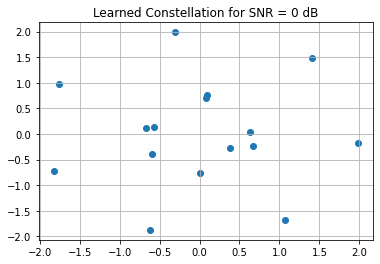

---SNR = 2 dB---
epoch 0: Loss = 2.7414 dB
epoch 500: Loss = 2.6186 dB
epoch 1000: Loss = 2.6349 dB
epoch 1500: Loss = 2.6672 dB
epoch 2000: Loss = 2.6285 dB
epoch 2500: Loss = 2.6106 dB
epoch 3000: Loss = 2.6212 dB
epoch 3500: Loss = 2.6368 dB
epoch 4000: Loss = 2.6472 dB


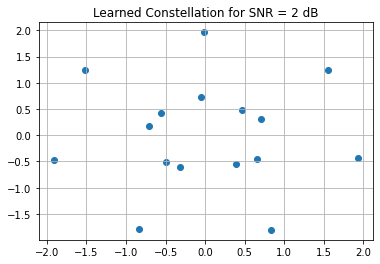

---SNR = 4 dB---
epoch 0: Loss = 2.3228 dB
epoch 500: Loss = 2.2293 dB
epoch 1000: Loss = 2.2267 dB
epoch 1500: Loss = 2.2321 dB
epoch 2000: Loss = 2.1977 dB
epoch 2500: Loss = 2.2193 dB
epoch 3000: Loss = 2.2225 dB
epoch 3500: Loss = 2.2128 dB
epoch 4000: Loss = 2.2074 dB


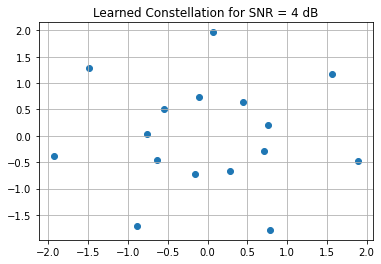

---SNR = 6 dB---
epoch 0: Loss = 1.8479 dB
epoch 500: Loss = 1.7312 dB
epoch 1000: Loss = 1.7238 dB
epoch 1500: Loss = 1.7482 dB
epoch 2000: Loss = 1.7313 dB
epoch 2500: Loss = 1.7556 dB
epoch 3000: Loss = 1.7348 dB
epoch 3500: Loss = 1.7533 dB
epoch 4000: Loss = 1.7586 dB


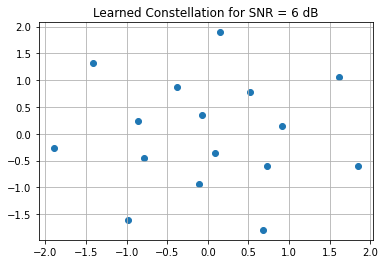

---SNR = 8 dB---
epoch 0: Loss = 1.3668 dB
epoch 500: Loss = 1.2469 dB
epoch 1000: Loss = 1.2701 dB
epoch 1500: Loss = 1.2397 dB
epoch 2000: Loss = 1.2425 dB
epoch 2500: Loss = 1.2549 dB
epoch 3000: Loss = 1.2492 dB
epoch 3500: Loss = 1.2497 dB
epoch 4000: Loss = 1.2466 dB


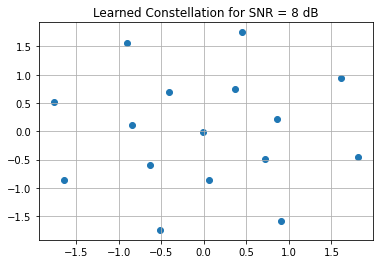

---SNR = 10 dB---
epoch 0: Loss = 0.8715 dB
epoch 500: Loss = 0.7529 dB
epoch 1000: Loss = 0.7724 dB
epoch 1500: Loss = 0.7643 dB
epoch 2000: Loss = 0.7653 dB
epoch 2500: Loss = 0.7663 dB
epoch 3000: Loss = 0.7541 dB
epoch 3500: Loss = 0.7593 dB
epoch 4000: Loss = 0.7739 dB


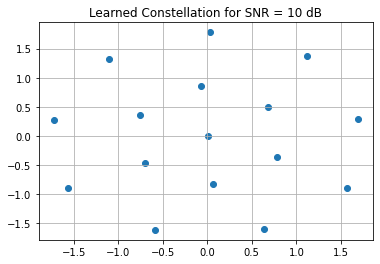

In [ ]:
P = 1 # normalization parameter
SNRdBs = np.array([0, 2, 4, 6, 8, 10]) 
SNRs = 10**(SNRdBs/10)
# Initialize network
mapper = Mapper()
demap = Demapper()

for (k,snr) in enumerate(SNRs):
    sigma2 = P/snr
    print(f'---SNR = {SNRdBs[k]} dB---')

    # Optimizer
    optimizer = optim.Adam(list(mapper.parameters()) + list(demap.parameters()), lr=0.01)
    
    # Training loop
    for j in range(4001):
        xhat = mapper(onehot_t)
        xhat = normalization(xhat, P)
        yhat = awgn(xhat, sigma2)
        l = demap(yhat)
        loss = loss_fn(l, a_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printout and visualization
        if j % 500 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy()/np.log(2) :.4f} dB')
        if loss < 1e-3:
            break
    # Data for the plots
    a_plot = np.arange(M)
    onehot_plot = np.array([one_hot(a_plot[i], M) for i in range(M)])
    learned_x = mapper(torch.tensor(onehot_plot).float())
    learned_x = normalization(learned_x, P).detach().numpy()
    plt.scatter(learned_x[:,0], learned_x[:,1])
    plt.title(f'Learned Constellation for SNR = {SNRdBs[k]} dB')
    plt.grid()
    plt.show()

* 4) For a binary representation of the message, implement a non-linear NN with m = 4 inputs and 2 outputs as mapper at the transceiver and a non-linear NN with 2 inputs terminated by a linear layer with m = 4 outputs as demapper at the receiver.


In [ ]:
class Mapper2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(4, 10)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(10, 10)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(10, 2)
        
    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        return self.lin3(y)

In [ ]:
class Demapper2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(2, 20)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(20, 20)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(20, 20)
        self.act3 = nn.ReLU()
        self.lin4 = nn.Linear(20, 20)
        self.act4 = nn.ReLU()
        self.lin5 = nn.Linear(20, 4)
        
    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        y = self.act3(self.lin3(y))
        return self.lin5(self.act4(self.lin4(y)))

* 5) Jointly train mapper and demapper w.r.t. BCE loss on LPRs for SNR equal to $\{0, 2, \dots , 10\}$ dB and plot the learned constellations.

* 6) Verify if the learned bit mappings are Gray.

In [ ]:
def get_labeling(msg):
    label = np.array([[0,0,0,0], [0,0,0,1], [0,0,1,1], [0,0,1,0], [0,1,1,0], [0,1,1,1], [0,1,0,1], [0,1,0,0],
                     [1,0,0,0], [1,0,0,1], [1,0,1,1], [1,0,1,0], [1,1,1,0], [1,1,1,1], [1,1,0,1], [1,1,0,0]])
    return label[msg, :]

In [ ]:
# Generate data
N = 40000
bits = np.random.choice(range(2), size= N)
bits = bits.reshape(-1,4)
# convert array to tensors
bits_t = torch.tensor(bits).float()
# loss function
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
# Batches
batch_size = 1000
num_epochs = 5001
dataloader = torch.utils.data.DataLoader(bits_t,
                                         batch_size=batch_size)

---SNR = 4 dB---
epoch 0: Loss = 0.8974 dB
epoch 500: Loss = 0.5717 dB
epoch 1000: Loss = 0.5905 dB
epoch 1500: Loss = 0.5810 dB
epoch 2000: Loss = 0.5744 dB
epoch 2500: Loss = 0.6036 dB
epoch 3000: Loss = 0.5736 dB
epoch 3500: Loss = 0.5801 dB
epoch 4000: Loss = 0.5686 dB
epoch 4500: Loss = 0.5787 dB
epoch 5000: Loss = 0.5764 dB


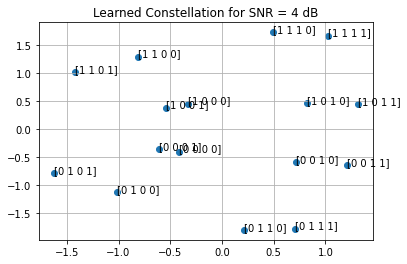

---SNR = 6 dB---
epoch 0: Loss = 0.4667 dB
epoch 500: Loss = 0.4601 dB
epoch 1000: Loss = 0.4398 dB
epoch 1500: Loss = 0.4489 dB
epoch 2000: Loss = 0.4376 dB
epoch 2500: Loss = 0.4442 dB
epoch 3000: Loss = 0.4337 dB
epoch 3500: Loss = 0.4376 dB
epoch 4000: Loss = 0.4615 dB
epoch 4500: Loss = 0.4592 dB
epoch 5000: Loss = 0.4377 dB


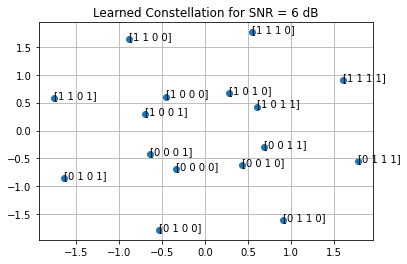

---SNR = 8 dB---
epoch 0: Loss = 0.3246 dB
epoch 500: Loss = 0.3129 dB
epoch 1000: Loss = 0.3259 dB
epoch 1500: Loss = 0.3108 dB
epoch 2000: Loss = 0.3048 dB
epoch 2500: Loss = 0.3268 dB
epoch 3000: Loss = 0.3095 dB
epoch 3500: Loss = 0.3374 dB
epoch 4000: Loss = 0.3348 dB
epoch 4500: Loss = 0.3133 dB
epoch 5000: Loss = 0.3108 dB


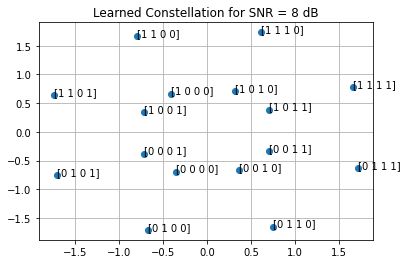

---SNR = 10 dB---
epoch 0: Loss = 0.2143 dB
epoch 500: Loss = 0.2144 dB
epoch 1000: Loss = 0.2057 dB
epoch 1500: Loss = 0.1971 dB
epoch 2000: Loss = 0.2220 dB
epoch 2500: Loss = 0.2145 dB
epoch 3000: Loss = 0.1949 dB
epoch 3500: Loss = 0.2116 dB
epoch 4000: Loss = 0.2195 dB
epoch 4500: Loss = 0.2056 dB
epoch 5000: Loss = 0.1949 dB


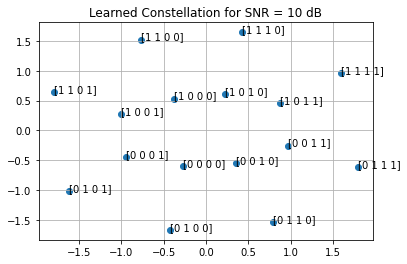

In [ ]:
P = 1 # normalization parameter
SNRdBs = np.array([4, 6, 8, 10]) 
SNRs = 10**(SNRdBs/10)

# Initialize network
mapper = Mapper2()
demap = Demapper2()



for (k,snr) in enumerate(SNRs):
    sigma2 = P/snr
    print(f'---SNR = {SNRdBs[k]} dB---')

    # Optimizer
    optimizer = optim.Adam(list(mapper.parameters()) + list(demap.parameters()), lr=0.01)

    # Training loop
    for j in range(num_epochs):
        for b_t in (dataloader):
            xhat = mapper(b_t)
            xhat = normalization(xhat, P)
            yhat = awgn(xhat, sigma2)
            l = demap(yhat)
            loss = loss_fn(l, b_t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Printout and visualization
        if j % 500 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy()/np.log(2) :.4f} dB')
        if loss < 1e-3:
            break
    # Data for the plots
    a_plot = np.arange(M)
    b_plot = get_labeling(a_plot)
    learned_x = mapper(torch.tensor(b_plot).float())
    learned_x = normalization(learned_x, P).detach().numpy()    
    plt.scatter(learned_x[:,0], learned_x[:,1])
    for i in range(M):
        plt.annotate(f'{b_plot[i,:]}', (learned_x[i,0], learned_x[i,1]) )
    plt.title(f'Learned Constellation for SNR = {SNRdBs[k]} dB')
    plt.grid()
    plt.show()

##### Problem 6.4 - PCA 
Generate a data set consisting of $n = 10 000$ vectors of dimension
$N = 2$ by sampling from a joint Gaussian distribution with covariance matrix and mean
vector given by

$$ C = \begin{bmatrix}
1 & 0.5 \\
0.5 & 2
\end{bmatrix}$$
$$ \mu = \begin{bmatrix}
1 \\
2
\end{bmatrix}$$


* 1) Implement a PCA autoencoder with dimensionality reduction bottleneck with M =1. Train the NN w.r.t. to the MSE and scatterplot the data and its reconstruction,i.e., its principal component.

In [ ]:
# Covariance and mean
cov = np.array([[1, 0.5],[0.5, 2]])
mean = np.array([1, 2])
# generate data
x = np.random.multivariate_normal(mean, cov, 100000)

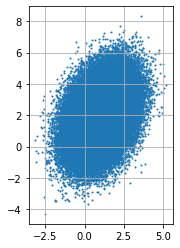

In [ ]:
# Plot
plt.scatter(x[:, 0], x[:, 1], s=1)
plt.gca().set_aspect('equal')
plt.grid()

In [ ]:
class PCA(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = torch.nn.Linear(2, 1)
        self.lin2 = torch.nn.Linear(1, 2)
    def forward(self, x):
        z = self.lin1(x)
        return self.lin2(z), z

In [ ]:
pca = PCA()

_x = torch.tensor(x).float()

optimizer = torch.optim.Adam(list(pca.parameters()))
loss_fn = torch.nn.MSELoss()
for i in range(6001):
    _xhat, _ = pca(_x)
    optimizer.zero_grad()
    loss = loss_fn(_x, _xhat)
    loss.backward()
    optimizer.step()
    if i % 500 == 0:
        print(f'(epoch {i}) loss = {loss :.4f}')

(epoch 0) loss = 4.6490
(epoch 500) loss = 0.9801
(epoch 1000) loss = 0.5648
(epoch 1500) loss = 0.4630
(epoch 2000) loss = 0.4140
(epoch 2500) loss = 0.4003
(epoch 3000) loss = 0.3973
(epoch 3500) loss = 0.3967
(epoch 4000) loss = 0.3965
(epoch 4500) loss = 0.3965
(epoch 5000) loss = 0.3965
(epoch 5500) loss = 0.3965
(epoch 6000) loss = 0.3965


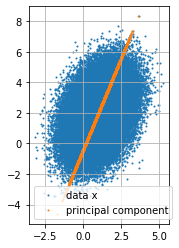

In [ ]:
# Plot
_xhat, _z = pca(_x)
xhat = _xhat.detach().numpy()
plt.scatter(x[:, 0], x[:, 1], s=1, label='data x')
plt.scatter(xhat[:, 0], xhat[:, 1], s=1, label='principal component')
plt.legend()
plt.gca().set_aspect('equal')
plt.grid()

* 2) Compare to what you get when using sklearn.decomposition.PCA from the
Scikit-Learn package.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=1)
pca.fit(x)
x_pca = pca.transform(x)
x_new = pca.inverse_transform(x_pca)

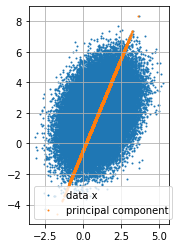

In [ ]:
# Plot
plt.scatter(x[:, 0], x[:, 1], s=1, label='data x')
plt.scatter(x_new[:, 0], x_new[:, 1], s=1, label='principal component')
plt.legend()
plt.gca().set_aspect('equal')
plt.grid()